<a href="https://colab.research.google.com/github/tatsuhiko-ikeda3/GAN_with_VIT/blob/main/original_vit_50epoch_flower_D_v_G_sa_FID_KID_devide_1_color_relativistic1_hinge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#パッケージのダウンロード


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import argparse

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
import torchvision.transforms as transforms

In [ ]:
import torchvision.datasets as dset

In [ ]:
import torchvision.utils as vutils

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [ ]:
import glob

In [ ]:
from torch.utils.data import Dataset
from PIL import Image

In [ ]:
from torch.utils.data import DataLoader
import torchvision

In [ ]:
!pip install torchmetrics
!pip install torchmetrics[image]

!pip install torch-fidelity

from torchmetrics.image.inception import InceptionScore


import torchmetrics
import torch_fidelity

import torch
_ = torch.manual_seed(123)
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(feature=2048)

from torchmetrics.image.kid import KernelInceptionDistance


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 4.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 3.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth


  0%|          | 0.00/91.2M [00:00<?, ?B/s]

In [ ]:
kid = KernelInceptionDistance(subset_size=15)

/usr/local/lib/python3.8/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [ ]:
#ハイパーパラメータの設定

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epoch", type = int, default=50)
parser.add_argument("--batch_size", type = int, default=32)
parser.add_argument("--lr_g", type = float, default=2e-4)
parser.add_argument("--lr_d", type = float, default=3e-4)
parser.add_argument("--nch_g", type = int, default=64)
parser.add_argument("--nch_d", type = int, default=64)
parser.add_argument("--z_dim", type = int, default=100)
parser.add_argument("--beta1", type = float, default=0.5)

opt = parser.parse_args(args=[])
print(opt)

Namespace(batch_size=32, beta1=0.5, lr_d=0.0003, lr_g=0.0002, n_epoch=50, nch_d=64, nch_g=64, z_dim=100)


In [ ]:
class ImageDataset(Dataset):
    def __init__(self,  transform = None):
        super().__init__()
        self.file_list = glob.glob("/content/drive/MyDrive/102flowers (2)/jpg/*.jpg")#/content/drive/MyDrive/img_align_celeba.zip
        #self.file_list = glob.glob("/content/drive/MyDrive/cityscapes/cityscapes_data/train/*.jpg" )#/content/drive/MyDrive/cityscapes/cityscapes_data/train
        #self.file_list = glob.glob("/content/drive/MyDrive/Test/**/*.jpg" )#fruits
       # self.file_list = glob.glob("/content/drive/MyDrive/img_align_celeba.zip/jpg/*.jpg")#C:\Users\ikeda\Downloads\img_align_celeba\img_align_celeba
        #self.file_list = glob.glob("/content/drive/MyDrive/–¢Šm”F 758452(1).crdownload/*.jpg")
        self.transform = transform

    
    def __getitem__(self, index):
        if self.transform is not None:
            img = self.transform(Image.open(self.file_list[index]))
        else:
            img = Image.open(self.file_list[index])
        return img
    
    def __len__(self):
        return len(self.file_list)

In [ ]:
from torchvision.transforms.transforms import CenterCrop

transform = transforms.Compose([
    
    transforms.Resize(80),
    transforms.CenterCrop(64),
    transforms.ToTensor(), 
                               transforms.Normalize((0.5,),(0.5,))])

In [ ]:
#dataset = dset.MNIST("./", train = True, download = True,transform = transform)
dataset = ImageDataset(transform = transform)
#dataset = torchvision.datasets.CelebA("./", split = "test", download = True,transform = transform) #Cityscapes
#dataset = torchvision.datasets.Cityscapes("C:\Users\ikeda\Downloads\cityscapes\cityscapes_data\cityscapes_data", split='train', mode='fine', target_type='color')


In [ ]:
dataloader = DataLoader(dataset = dataset, batch_size = opt.batch_size,num_workers = 2,  shuffle = True)

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        

In [ ]:
#モデルの設定

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x   

In [ ]:
class ResidualBlock_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE_G(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x   

In [ ]:
class ResidualBlock_1(nn.Module):#実質パディングとスペクトラム正規化とインスタンス正規化
  def __init__(self, in_channels):
    super().__init__()
    self.conv_layers = nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),
        nn.ReLU(inplace = True),
        
        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),
        
    )
  def forward(self, x):
    out = self.conv_layers(x)
    out = out + x
    return out

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        #out_channels = in_channels // n_divide
        out_channels = 1

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 
     

    def forward(self, x):
        B, C, H, W = x.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)
        
        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)#(B,H*W softmax, H*W)
        
        o =torch.bmm(hx, attention)#(b,c,h*w )*(B,H*W softmax, H*W) -> (b,c,h*w)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [ ]:
#import torch
#from layers.transformer.ScaledDotProductAttention import ScaledDotProductAttention
#from torch import nn


class MultiHeadAttention(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()  
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.Conv2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 

        self.se_block_0 = SE(in_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)

        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)
        
        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)
        
        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out


In [ ]:

class MultiHeadAttention_G(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()  
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 

        self.se_block_0 = SE_G(in_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        qkv = self.relu(qkv)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)
        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)
        
        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)
        
        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out

In [ ]:
class SelfAttention_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        out_channels = in_channels // n_divide
      #  out_channels = 1

        self.fx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.gx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 
     

    def forward(self, x):
        B, C, H, W = x.size()
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)
        
        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)
        
        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [ ]:
class PF(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels) 
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) -x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x= self.flat(x)
        x = self.conv1(x) 
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x 

In [ ]:
"""    def __init__(self, in_channels):
        super().__init__()
        n_divide = 8
        out_channels = in_channels // n_divide
        self.dim = 3

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels) 
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool= nn.AvgPool2d(kernel_size =self.dim , stride = 1, padding = 0, count_include_pad=False)
        self.sigmoid = nn.Sigmoid()
         

    def forward(self, x):
        B, C, H, W = x.size()
        z = self.pre_bn(x)
        z = self.pool(z, self.dim = H)

        z = self.conv1(z) 
        z = self.relu(z)

        z = self.conv2(z) 
        z = self.sigmoid(z)

        z = torch.einsum("bchw,bchw->bchw",(x, z))
        out = x + self.gamma * z
        return out
"""

'    def __init__(self, in_channels):\n        super().__init__()\n        n_divide = 8\n        out_channels = in_channels // n_divide\n        self.dim = 3\n\n        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm\n        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#\n        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#\n        self.gamma = nn.Parameter(torch.zeros(1))\n        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 \n        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1\n        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))\n        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること\n        self.pre_bn = nn.BatchNorm2d(in_channels) \n        self.bn =

In [ ]:
class SE(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
           # nn.Linear(channel, channel// reduction , bias=False),
            (nn.Conv2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            (nn.Conv2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        #y = self.avg_pool(x).view(b, c)
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)




In [ ]:
class SE_G(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            #nn.Linear(channel, channel// reduction , bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [ ]:
#nn.ConvTranspose2d
class PF_G(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) - x 
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x = self.flat(x)
        x = self.conv1(x) 
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x 

In [ ]:
"""(((W - K + 2P)/S) + 1)
    Here W = Input size
    K = Filter size
    S = Stride
    P = Padding 
    ((Input_size-kernel_size + 2*Padding)/stride)+ 1
    この式を使用できます[(W−K+2P)/S]+1。

W は入力ボリュームです - あなたの場合は 128
Kはカーネルサイズです - あなたの場合は5です
P はパディングです - あなたの場合は 0 だと思います
S はストライドです - あなたが提供していません。
したがって、次の式に入力します。
for example
Output_Shape = (128-5+0)/1+1

Output_Shape = (124,124,40)
output==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W
    """



'(((W - K + 2P)/S) + 1)\n    Here W = Input size\n    K = Filter size\n    S = Stride\n    P = Padding \n    ((Input_size-kernel_size + 2*Padding)/stride)+ 1\n    この式を使用できます[(W−K+2P)/S]+1。\n\nW は入力ボリュームです - あなたの場合は 128\nKはカーネルサイズです - あなたの場合は5です\nP はパディングです - あなたの場合は 0 だと思います\nS はストライドです - あなたが提供していません。\nしたがって、次の式に入力します。\nfor example\nOutput_Shape = (128-5+0)/1+1\n\nOutput_Shape = (124,124,40)\noutput==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W\n    '

In [ ]:
class VIT(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)
        
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 3//2)
        self.attention = SelfAttention(in_channels)
        self.se_block_0 = SE(in_channels)
        self.se_block_1 = SE(out_channels)

        self.flat = nn.Flatten()

        self.linear_1 = nn.Linear(32,64, bias=False)
        self.linear_2 = nn.Linear( 32,32, bias=False)#if ( 64,32, bias=False)  -> mat1 and mat2 shapes cannot be multiplied (131072x32 and 64x32)
        
      
    def shortcut(self, x):
        x = self.conv3(x)
        #x = self.se_block_1(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        
        identity = x#入力
        x = self.pre_bn(x)
       # x = self.se_block_0(x)
        x = self.attention(x) - x
        x = x + identity
        

        identity = x#入力
        x = self.pre_bn(x)
        b, c, h, w = x.size()
        #x = self.conv1(x) 
       # x= self.flat(x)
        #print(x.size())

        x = self.linear_1(x).view(b, -1, h, w)
        x = self.relu(x)
        x = self.linear_2(x).view(b, -1, h, w)

        #x = x.view(b, -1, h, w)
        #print(x.size())
        #print(self.shortcut(identity).size())
        x =  self.shortcut(identity) + x
        
        #x = self.se_block_1(x)
        #x = x + self.shortcut(identity)
        x = self.bn(x)
        
        return x 

In [ ]:
#nn.ConvTranspose2d
class VIT_G(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size=1 -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.attention = MultiHeadAttention_G(in_channels)
      
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.attention(x) - x
        x = x + identity

        #identity = x#入力
        x = self.pre_bn(x)
        x = self.conv1(x) 
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x 

In [ ]:
class Generator(nn.Module):
    def __init__(self,pf, vit, resnet,res_net,sa,z_dim = opt.z_dim, ngf = opt.nch_g, nc = 3):# ものくろだからnc=1 カラーならnc=3
        super().__init__()
        
        self.convt1 = self.conv_trans_layers(z_dim, 8*ngf, 4,1,0 )# ngf = the number of channels 
        
        self.convt2 = self.conv_trans_layers(8*ngf, 4*ngf, 4, 2, 1 )
        self.convt3 = self.conv_trans_layers(4*ngf,  2*ngf, 4,2,1)
        self.convt4 = self.conv_trans_layers(2*ngf,  ngf, 4,2,1 )

        self.pf1 = pf(z_dim, 8*ngf)
        self.vit1 = vit(z_dim, 8*ngf)

        self.pf2 = pf(8*ngf, 4*ngf)
        self.vit2 = vit(8*ngf, 4*ngf)

        self.pf3 = pf(4*ngf,  2*ngf)
        self.vit3 = vit(4*ngf,  2*ngf)

        self.pf4 = pf(2*ngf,  ngf)
        self.vit4 = vit(2*ngf,  ngf)

        self.convt5 = nn.Sequential(
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1),
            #self.conv_trans_layers(ngf, nc, 4,2,1  )
            nn.Tanh()
        )
        

    @staticmethod
    def conv_trans_layers(in_channels, out_channels, kernel_size, stride, padding, has_norm=True,attention=True, res_net= False, se = False):
        layers = [nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding))]#spectralnorm
        if has_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        #layers.append(nn.ReLU(inplace = True))
        layers.append(nn.LeakyReLU(0.2, inplace = True)) 
        if se:
            layers.append(SE_G(out_channels)) 
        if attention:
            layers.append(SelfAttention_G(out_channels))
        if res_net:
            layers.append(ResidualBlock_G(out_channels))
        


        net = nn.Sequential(*layers)#listのアンパック

        return net
    
    def forward(self, x):      
        out = self.convt1(x)

        out = self.convt2(out)       

        out = self.convt3(out)
      
        out = self.convt4(out)

        out = self.convt5(out)


        return out

In [ ]:
from pickle import FALSE
class Discriminator(nn.Module):
    def __init__(self,pf,vit ,resnet,res_net,sa,nc = 3, ndf = opt.nch_d):# ものくろだからnc=1 カラーならnc=3
        super().__init__()
        self.conv1 = self.conv_layers(nc, ndf)
        self.pf1 = pf(nc,ndf)
        self.vit1 = vit(nc,ndf)

        self.conv2 = self.conv_layers(ndf, 2*ndf )
        self.pf2 = pf(ndf, 2*ndf)
        self.vit2 = vit(ndf, 2*ndf)

        self.conv3 = self.conv_layers(2*ndf, 4*ndf )
        self.pf3 = pf(2*ndf, 4*ndf )
        self.vit3 = vit(2*ndf, 4*ndf )

        self.conv4 = self.conv_layers(4*ndf, 8*ndf)
        self.pf4 = pf(4*ndf, 8*ndf)
        self.vit4 = vit(4*ndf, 8*ndf)

        self.vit5 = vit(8*ndf, 16*ndf)

        self.conv5 =  nn.Conv2d(8*ndf, 1,  4)
        #self.conv6 =  nn.Conv2d(16*ndf, 1,  4)

        
    @staticmethod
    def conv_layers(in_channels, out_channels, kernel_size=4, stride=2, padding=1, has_batch_norm = True, attention = False, res_net = False, se = False):
        layers = [nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))]
        if has_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        if se:
            layers.append(SE(out_channels))
        if attention:
            layers.append(SelfAttention(out_channels))

        if res_net:
            layers.append(ResidualBlock(out_channels))

       
        net = nn.Sequential(*layers)#listのアンパック
       
        return net
    
    def forward(self, x):
        out = self.conv1(x)

        out = self.vit2(out)    

        out = self.vit3(out)
      
        out = self.vit4(out)

        out = self.conv5(out)

        return out

In [ ]:
#モデルのトレーニング

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
device

device(type='cuda')

In [ ]:
netG = Generator(PF_G,VIT_G,ResidualBlock,ResidualBlock_1,SelfAttention, z_dim=opt.z_dim , ngf=opt.nch_g ).to(device)
netG.apply(weights_init)
print(netG)

netD = Discriminator(PF,VIT,ResidualBlock,ResidualBlock_1,SelfAttention, nc = 3 , ndf=opt.nch_d ).to(device)# ものくろだからnc=1 カラーならnc=3
netD.apply(weights_init)
print(netD)

Generator(
  (convt1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): SelfAttention_G(
      (fx_1x1): ConvTranspose2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
      (gx_1x1): ConvTranspose2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
      (hx_1x1): ConvTranspose2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
      (softmax): Softmax(dim=-2)
    )
  )
  (convt2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): SelfAttention_G(
      (fx_1x1): ConvTranspose2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      (gx_1x1): ConvTranspose2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      (hx_1x1): ConvTranspo

In [ ]:
#criterion = nn.BCELoss()
#criterion = torch.nn.HingeEmbeddingLoss()
optimizerG = optim.Adam(netG.parameters(), lr = opt.lr_g, betas= (opt.beta1, 0.999), weight_decay = 1e-5)
optimizerD = optim.Adam(netD.parameters(), lr = opt.lr_d, betas= (opt.beta1, 0.999), weight_decay = 1e-5)

100%|██████████| 103/103 [01:56<00:00,  1.14s/it]


epoch: 0, lossD:1.9045944734684472, lossG:2.646529639808877,lossG_fake:1.3972599309624978, lossG_real:1.2492697186840391 ,equality:0.14799021227845865


/usr/local/lib/python3.8/dist-packages/scipy/linalg/_matfuncs_sqrtm.py:186: RuntimeWarning: invalid value encountered in double_scalars
  arg2 = norm(X.dot(X) - A, 'fro')**2 / norm(A, 'fro')


evaluate:124.93536376953125,kid_mean:0.060630325227975845, kid_std:0.014140198938548565,kid_:(tensor(0.0606), tensor(0.0141))


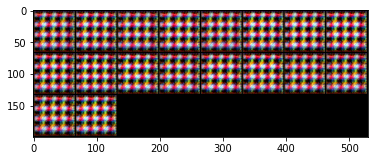

100%|██████████| 103/103 [00:51<00:00,  2.01it/s]


epoch: 1, lossD:1.7817583697513468, lossG:2.5364255604234716,lossG_fake:1.3911888935033558, lossG_real:1.145236661133257 ,equality:0.2459522323700989


evaluate:117.7734146118164,kid_mean:0.06369529664516449, kid_std:0.03175188973546028,kid_:(tensor(0.0637), tensor(0.0318))


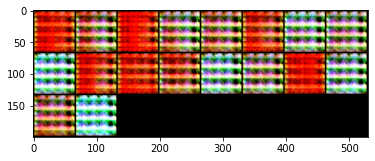

100%|██████████| 103/103 [00:51<00:00,  2.01it/s]


epoch: 2, lossD:1.9827505801487895, lossG:2.146806638217667,lossG_fake:1.1760103783561189, lossG_real:0.9707962714352654 ,equality:0.2052141069208535


evaluate:104.02130126953125,kid_mean:0.05625523626804352, kid_std:0.027348745614290237,kid_:(tensor(0.0563), tensor(0.0273))


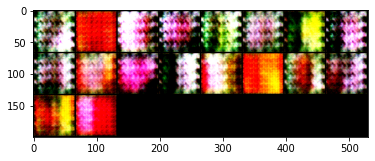

100%|██████████| 103/103 [00:51<00:00,  1.99it/s]


epoch: 3, lossD:2.0170883310651315, lossG:2.0354200497414303,lossG_fake:1.0748987388842315, lossG_real:0.9605213096998271 ,equality:0.11437742918440441


evaluate:104.85045623779297,kid_mean:0.06005208194255829, kid_std:0.031034188345074654,kid_:(tensor(0.0601), tensor(0.0310))


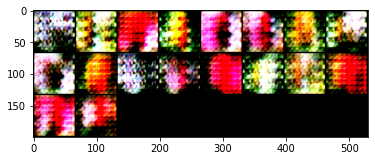

100%|██████████| 103/103 [00:51<00:00,  2.00it/s]


epoch: 4, lossD:1.9993950915568084, lossG:2.0532487017437093,lossG_fake:1.1057192064026027, lossG_real:0.9475294947624207 ,equality:0.15818971164018203


evaluate:110.342529296875,kid_mean:0.06211511045694351, kid_std:0.030393097549676895,kid_:(tensor(0.0621), tensor(0.0304))


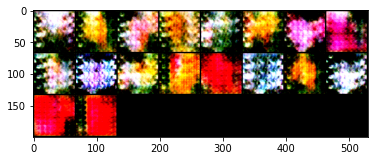

100%|██████████| 103/103 [00:51<00:00,  2.01it/s]


epoch: 5, lossD:2.014813947446138, lossG:2.081061853945834,lossG_fake:1.08582689576936, lossG_real:0.9952349564404164 ,equality:0.0905919393289436


evaluate:111.29029083251953,kid_mean:0.06288748234510422, kid_std:0.03502010554075241,kid_:(tensor(0.0629), tensor(0.0350))


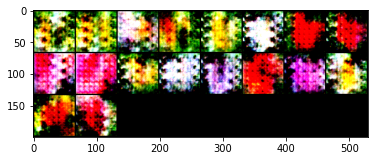

100%|██████████| 103/103 [00:51<00:00,  1.98it/s]


epoch: 6, lossD:1.9979740369667127, lossG:2.048337179480247,lossG_fake:1.0410950565801083, lossG_real:1.0072421281083117 ,equality:0.03385292847179655


evaluate:113.26898193359375,kid_mean:0.07315919548273087, kid_std:0.03822460398077965,kid_:(tensor(0.0732), tensor(0.0382))


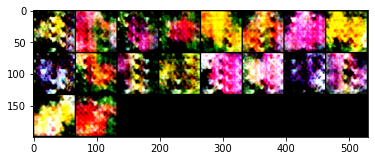

100%|██████████| 103/103 [00:51<00:00,  2.00it/s]


epoch: 7, lossD:2.0176351556500185, lossG:2.054147417105517,lossG_fake:1.0380298217523445, lossG_real:1.016117598825288 ,equality:0.021912222927056524


evaluate:108.53963470458984,kid_mean:0.06451904028654099, kid_std:0.03508026525378227,kid_:(tensor(0.0645), tensor(0.0351))


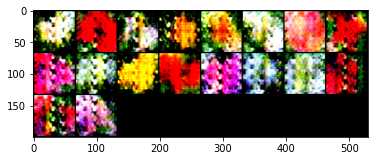

100%|██████████| 103/103 [00:51<00:00,  2.00it/s]


epoch: 8, lossD:2.0070781244814975, lossG:2.028532075650484,lossG_fake:1.0342013407679438, lossG_real:0.9943307458775715 ,equality:0.03987059489037226


evaluate:110.1263656616211,kid_mean:0.06151565536856651, kid_std:0.031220121309161186,kid_:(tensor(0.0615), tensor(0.0312))


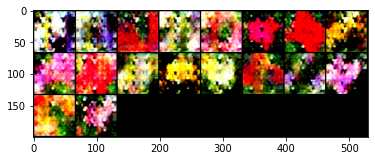

100%|██████████| 103/103 [00:52<00:00,  1.96it/s]


epoch: 9, lossD:2.005343020540997, lossG:2.0303174616063684,lossG_fake:1.0460095266694005, lossG_real:0.9843079285714232 ,equality:0.06170159809797726


evaluate:110.15460968017578,kid_mean:0.06256821006536484, kid_std:0.03523372858762741,kid_:(tensor(0.0626), tensor(0.0352))


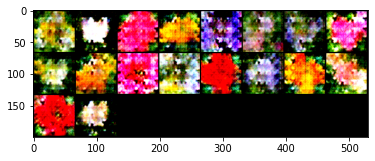

100%|██████████| 103/103 [00:51<00:00,  2.00it/s]


epoch: 10, lossD:2.0054208098106012, lossG:2.032243411517838,lossG_fake:1.039788372886991, lossG_real:0.9924550363161031 ,equality:0.047333336570887896


evaluate:107.64501953125,kid_mean:0.06966311484575272, kid_std:0.03517575562000275,kid_:(tensor(0.0697), tensor(0.0352))


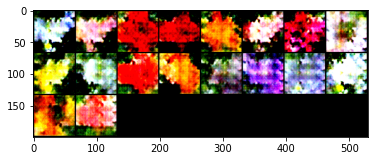

100%|██████████| 103/103 [00:51<00:00,  1.99it/s]


epoch: 11, lossD:2.0050101801029685, lossG:2.026641114244183,lossG_fake:1.020616123398531, lossG_real:1.0060249914243384 ,equality:0.014591131974192484


evaluate:108.62162017822266,kid_mean:0.05847089737653732, kid_std:0.028990548104047775,kid_:(tensor(0.0585), tensor(0.0290))


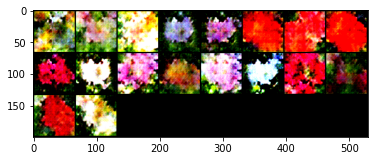

100%|██████████| 103/103 [00:51<00:00,  2.00it/s]


epoch: 12, lossD:2.0096637080016646, lossG:2.04410749731712,lossG_fake:1.04373458751197, lossG_real:1.0003729121198932 ,equality:0.04336167539207669


evaluate:113.74724578857422,kid_mean:0.06729967892169952, kid_std:0.03782132640480995,kid_:(tensor(0.0673), tensor(0.0378))


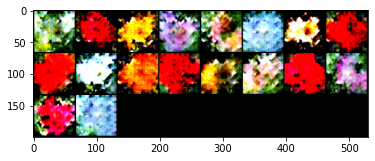

100%|██████████| 103/103 [00:51<00:00,  2.00it/s]


epoch: 13, lossD:2.0017776014735396, lossG:2.0370162065746715,lossG_fake:1.0522898684427575, lossG_real:0.9847263323450551 ,equality:0.06756353609770238


evaluate:115.61825561523438,kid_mean:0.0683542788028717, kid_std:0.037560831755399704,kid_:(tensor(0.0684), tensor(0.0376))


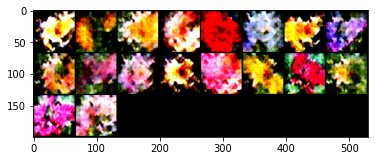

100%|██████████| 103/103 [00:51<00:00,  1.99it/s]


epoch: 14, lossD:2.0065256484503884, lossG:2.03994068127234,lossG_fake:1.0453419297644235, lossG_real:0.9945987567160893 ,equality:0.0507431730483342


evaluate:115.6801986694336,kid_mean:0.0715811550617218, kid_std:0.03677864745259285,kid_:(tensor(0.0716), tensor(0.0368))


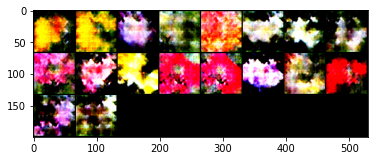

100%|██████████| 103/103 [00:51<00:00,  2.00it/s]


epoch: 15, lossD:2.0029182885457013, lossG:2.0339512211605184,lossG_fake:1.0378002854226862, lossG_real:0.9961509386312615 ,equality:0.041649346791424735


evaluate:115.0746078491211,kid_mean:0.07494137436151505, kid_std:0.039928656071424484,kid_:(tensor(0.0749), tensor(0.0399))


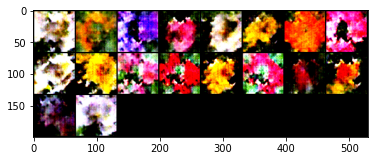

100%|██████████| 103/103 [00:51<00:00,  2.00it/s]


epoch: 16, lossD:2.0065300580367302, lossG:2.0253000340415435,lossG_fake:1.0454839346478286, lossG_real:0.979816094764228 ,equality:0.06566783988360059


evaluate:117.7986068725586,kid_mean:0.07653689384460449, kid_std:0.03720894828438759,kid_:(tensor(0.0765), tensor(0.0372))


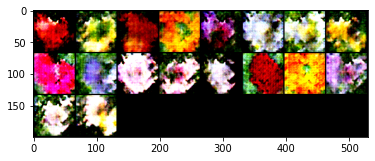

100%|██████████| 103/103 [00:52<00:00,  1.98it/s]


epoch: 17, lossD:2.002891728021566, lossG:2.028799576666749,lossG_fake:1.0440456618383094, lossG_real:0.9847539003612926 ,equality:0.05929176147701676


evaluate:117.69233703613281,kid_mean:0.07598983496427536, kid_std:0.03581864759325981,kid_:(tensor(0.0760), tensor(0.0358))


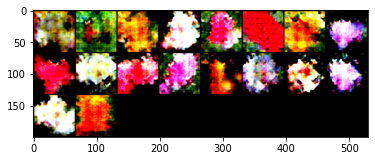

100%|██████████| 103/103 [00:51<00:00,  1.99it/s]


epoch: 18, lossD:2.001425321819713, lossG:2.0316965024448135,lossG_fake:1.0505607243880486, lossG_real:0.9811357850009955 ,equality:0.06942493938705308


evaluate:117.1303482055664,kid_mean:0.07800668478012085, kid_std:0.04154994338750839,kid_:(tensor(0.0780), tensor(0.0415))


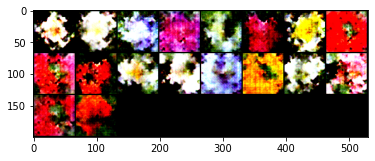

100%|██████████| 103/103 [00:51<00:00,  2.00it/s]


epoch: 19, lossD:2.0221988390950325, lossG:2.044438047316468,lossG_fake:1.0339627173340435, lossG_real:1.0104753346119113 ,equality:0.023487382722132244


evaluate:116.91754913330078,kid_mean:0.07763953506946564, kid_std:0.04259087145328522,kid_:(tensor(0.0776), tensor(0.0426))


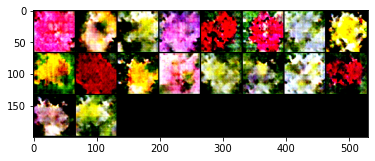

100%|██████████| 103/103 [00:51<00:00,  1.98it/s]


epoch: 20, lossD:2.0033284298424583, lossG:2.0212514817136005,lossG_fake:1.0241674410486685, lossG_real:0.9970840441370473 ,equality:0.027083396911621205


evaluate:114.76765441894531,kid_mean:0.07816903293132782, kid_std:0.03781208395957947,kid_:(tensor(0.0782), tensor(0.0378))


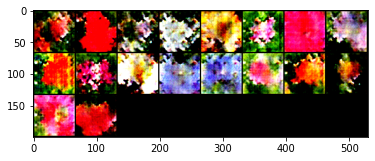

100%|██████████| 103/103 [00:51<00:00,  2.00it/s]


epoch: 21, lossD:2.0017921843575044, lossG:2.0225683450698853,lossG_fake:1.0375373930607028, lossG_real:0.985030945064952 ,equality:0.05250644799575077


evaluate:113.2139663696289,kid_mean:0.07704970985651016, kid_std:0.03917861729860306,kid_:(tensor(0.0770), tensor(0.0392))


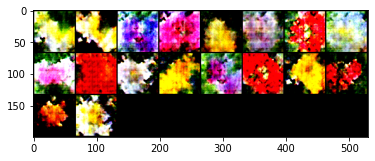

100%|██████████| 103/103 [00:51<00:00,  2.00it/s]


epoch: 22, lossD:2.002746992898219, lossG:2.0234563234940315,lossG_fake:1.0283203738407023, lossG_real:0.9951359525467586 ,equality:0.03318442129394372


evaluate:112.49859619140625,kid_mean:0.06799952685832977, kid_std:0.03807288035750389,kid_:(tensor(0.0680), tensor(0.0381))


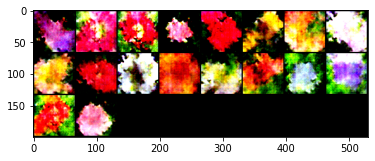

100%|██████████| 103/103 [00:52<00:00,  1.97it/s]


epoch: 23, lossD:2.001366696311432, lossG:2.025213256622981,lossG_fake:1.0291687950347235, lossG_real:0.996044455801399 ,equality:0.033124339233324473


evaluate:112.31074523925781,kid_mean:0.06755659729242325, kid_std:0.038394857197999954,kid_:(tensor(0.0676), tensor(0.0384))


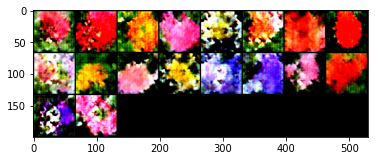

100%|██████████| 103/103 [00:51<00:00,  1.98it/s]


epoch: 24, lossD:2.0022176041186435, lossG:2.0268684683494196,lossG_fake:1.0303110219899891, lossG_real:0.9965574411512579 ,equality:0.033753580838731256


evaluate:113.91753387451172,kid_mean:0.07291527837514877, kid_std:0.03767872974276543,kid_:(tensor(0.0729), tensor(0.0377))


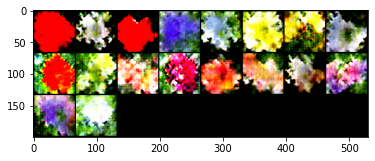

100%|██████████| 103/103 [00:51<00:00,  1.99it/s]


epoch: 25, lossD:2.0002289038260006, lossG:2.0262163287227595,lossG_fake:1.0246857028563046, lossG_real:1.0015306304959417 ,equality:0.02315507236036285


evaluate:112.84134674072266,kid_mean:0.07261959463357925, kid_std:0.04098965600132942,kid_:(tensor(0.0726), tensor(0.0410))


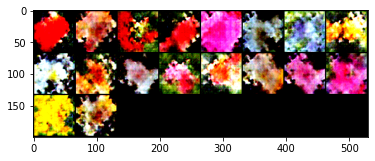

100%|██████████| 103/103 [00:52<00:00,  1.98it/s]


epoch: 26, lossD:2.000022911331029, lossG:2.0257072726499685,lossG_fake:1.041429638283924, lossG_real:0.9842776349447306 ,equality:0.05715200333919346


evaluate:111.64700317382812,kid_mean:0.0771947130560875, kid_std:0.040337059646844864,kid_:(tensor(0.0772), tensor(0.0403))


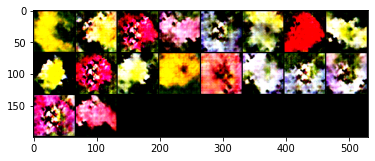

100%|██████████| 103/103 [00:51<00:00,  2.00it/s]


epoch: 27, lossD:2.000904994103515, lossG:2.028410449768733,lossG_fake:1.0207724507572582, lossG_real:1.0076379874377575 ,equality:0.013134463319500744


evaluate:111.6016616821289,kid_mean:0.06858423352241516, kid_std:0.0366138331592083,kid_:(tensor(0.0686), tensor(0.0366))


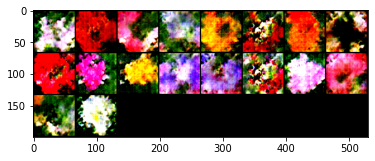

100%|██████████| 103/103 [00:51<00:00,  2.00it/s]


epoch: 28, lossD:2.01223757197556, lossG:2.037417483561247,lossG_fake:1.0236935146803994, lossG_real:1.0137239700382195 ,equality:0.009969544642179917


evaluate:111.06459045410156,kid_mean:0.06386839598417282, kid_std:0.034050047397613525,kid_:(tensor(0.0639), tensor(0.0341))


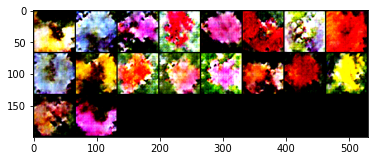

100%|██████████| 103/103 [00:51<00:00,  1.98it/s]


epoch: 29, lossD:1.998765239437807, lossG:2.0250247149791534,lossG_fake:1.038248242683781, lossG_real:0.9867764636150842 ,equality:0.05147177906869671


evaluate:110.4734878540039,kid_mean:0.06857333332300186, kid_std:0.03500032424926758,kid_:(tensor(0.0686), tensor(0.0350))


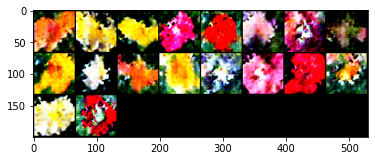

100%|██████████| 103/103 [00:51<00:00,  2.00it/s]


epoch: 30, lossD:2.0077951764597475, lossG:2.038661863039998,lossG_fake:1.0366185764664586, lossG_real:1.0020432865735396 ,equality:0.034575289892919026


evaluate:110.94342041015625,kid_mean:0.0731622576713562, kid_std:0.03982533887028694,kid_:(tensor(0.0732), tensor(0.0398))


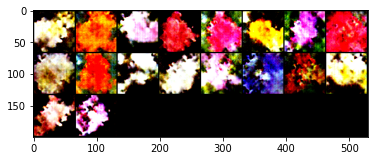

100%|██████████| 103/103 [00:51<00:00,  2.01it/s]


epoch: 31, lossD:1.9989491087719076, lossG:2.023089293137337,lossG_fake:1.0407222960759135, lossG_real:0.9823669906958793 ,equality:0.058355305380034195


evaluate:110.45240783691406,kid_mean:0.07191161811351776, kid_std:0.034298982471227646,kid_:(tensor(0.0719), tensor(0.0343))


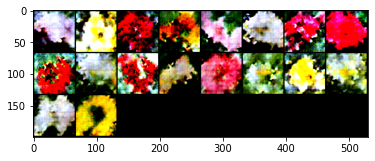

100%|██████████| 103/103 [00:52<00:00,  1.97it/s]


epoch: 32, lossD:1.9996314789485006, lossG:2.032927501548841,lossG_fake:1.0376489370771982, lossG_real:0.9952785864617061 ,equality:0.0423703506154921


evaluate:111.4651870727539,kid_mean:0.06920432299375534, kid_std:0.04042192921042442,kid_:(tensor(0.0692), tensor(0.0404))


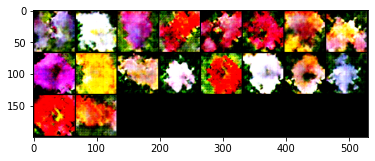

100%|██████████| 103/103 [00:51<00:00,  2.00it/s]


epoch: 33, lossD:1.997628070775745, lossG:2.034519339070737,lossG_fake:1.031016725938297, lossG_real:1.0035026137111256 ,equality:0.027514112227171372


evaluate:111.67390441894531,kid_mean:0.06920413672924042, kid_std:0.03427558019757271,kid_:(tensor(0.0692), tensor(0.0343))


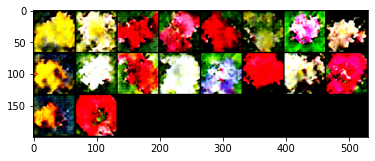

100%|██████████| 103/103 [00:51<00:00,  1.99it/s]


epoch: 34, lossD:1.9982151082418498, lossG:2.040237081861033,lossG_fake:1.0229022497112312, lossG_real:1.0173348211547704 ,equality:0.005567428556460863


evaluate:112.567138671875,kid_mean:0.06973502039909363, kid_std:0.03796372562646866,kid_:(tensor(0.0697), tensor(0.0380))


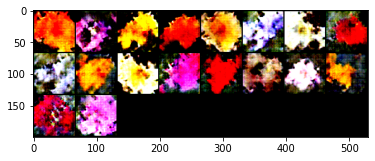

100%|██████████| 103/103 [00:51<00:00,  1.99it/s]


epoch: 35, lossD:1.9935054964232213, lossG:2.04549185280661,lossG_fake:1.0314089893137368, lossG_real:1.0140828571273286 ,equality:0.017326132186408216


evaluate:112.890625,kid_mean:0.06883542239665985, kid_std:0.03843208774924278,kid_:(tensor(0.0688), tensor(0.0384))


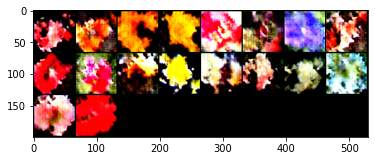

100%|██████████| 103/103 [00:51<00:00,  1.99it/s]


epoch: 36, lossD:1.9973683091043268, lossG:2.0396361119538833,lossG_fake:1.0336297970373653, lossG_real:1.0060063079722876 ,equality:0.027623489065077722


evaluate:113.15861511230469,kid_mean:0.06874263286590576, kid_std:0.03606817126274109,kid_:(tensor(0.0687), tensor(0.0361))


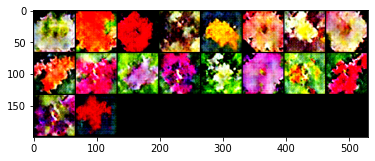

100%|██████████| 103/103 [00:51<00:00,  1.99it/s]


epoch: 37, lossD:1.991225905788755, lossG:2.052427680747023,lossG_fake:1.0567501511388613, lossG_real:0.9956775290294758 ,equality:0.061072622109385466


evaluate:113.13086700439453,kid_mean:0.06884443759918213, kid_std:0.03751537203788757,kid_:(tensor(0.0688), tensor(0.0375))


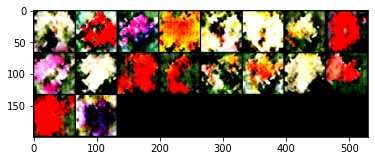

100%|██████████| 103/103 [00:51<00:00,  1.98it/s]


epoch: 38, lossD:1.9888901594773079, lossG:2.0671161482635054,lossG_fake:1.0414949476140216, lossG_real:1.0256212087510859 ,equality:0.01587373886293575


evaluate:113.70086669921875,kid_mean:0.07359607517719269, kid_std:0.04495006054639816,kid_:(tensor(0.0736), tensor(0.0450))


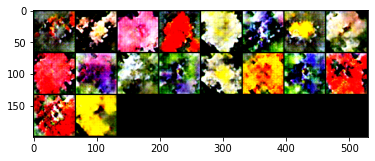

100%|██████████| 103/103 [00:51<00:00,  1.98it/s]


epoch: 39, lossD:1.9840268498485527, lossG:2.0722639479683442,lossG_fake:1.0483116414940472, lossG_real:1.023952296636637 ,equality:0.024359344857410203


evaluate:112.8813705444336,kid_mean:0.06637337058782578, kid_std:0.03495560213923454,kid_:(tensor(0.0664), tensor(0.0350))


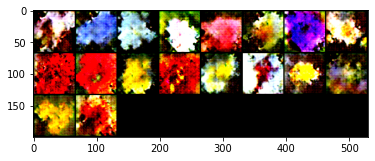

100%|██████████| 103/103 [00:52<00:00,  1.98it/s]


epoch: 40, lossD:1.9817932392787008, lossG:2.0838360485521337,lossG_fake:1.0595265042434618, lossG_real:1.0243095367857553 ,equality:0.03521696745770653


evaluate:111.8370361328125,kid_mean:0.06870515644550323, kid_std:0.03844085708260536,kid_:(tensor(0.0687), tensor(0.0384))


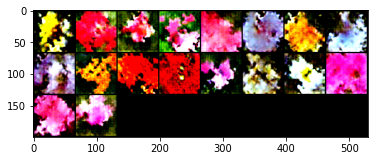

100%|██████████| 103/103 [00:51<00:00,  1.99it/s]


epoch: 41, lossD:1.9913064484457368, lossG:2.094504358699021,lossG_fake:1.0496585293880945, lossG_real:1.0448458339404134 ,equality:0.004812695447681037


evaluate:112.36559295654297,kid_mean:0.07460856437683105, kid_std:0.0426553338766098,kid_:(tensor(0.0746), tensor(0.0427))


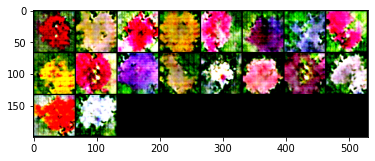

100%|██████████| 103/103 [00:51<00:00,  1.99it/s]


epoch: 42, lossD:1.9727532551126572, lossG:2.1017222520217156,lossG_fake:1.066316797895339, lossG_real:1.0354054599132352 ,equality:0.03091133798210377


evaluate:111.25885009765625,kid_mean:0.06787831336259842, kid_std:0.03654664009809494,kid_:(tensor(0.0679), tensor(0.0365))


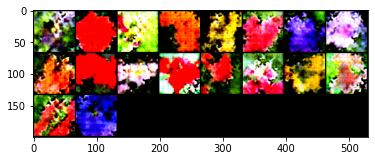

100%|██████████| 103/103 [00:52<00:00,  1.98it/s]


epoch: 43, lossD:1.969277223337044, lossG:2.140938761164841,lossG_fake:1.0997733155500542, lossG_real:1.0411654288328966 ,equality:0.058607886717157553


evaluate:111.1913070678711,kid_mean:0.07520246505737305, kid_std:0.03755449131131172,kid_:(tensor(0.0752), tensor(0.0376))


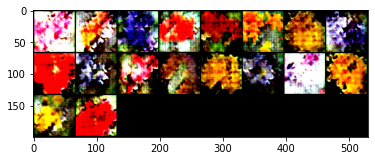

100%|██████████| 103/103 [00:51<00:00,  1.99it/s]


epoch: 44, lossD:1.961186242335051, lossG:2.1268801341936427,lossG_fake:1.0901115727656097, lossG_real:1.0367685550624886 ,equality:0.05334301770312111


evaluate:111.65740966796875,kid_mean:0.07156592607498169, kid_std:0.03907651826739311,kid_:(tensor(0.0716), tensor(0.0391))


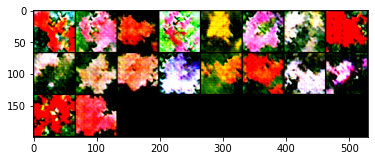

100%|██████████| 103/103 [00:51<00:00,  1.98it/s]


epoch: 45, lossD:1.9438948307222532, lossG:2.1570011643530096,lossG_fake:1.1169390180735912, lossG_real:1.040062148594162 ,equality:0.07687686947942929


evaluate:111.49769592285156,kid_mean:0.0768253356218338, kid_std:0.043234460055828094,kid_:(tensor(0.0768), tensor(0.0432))


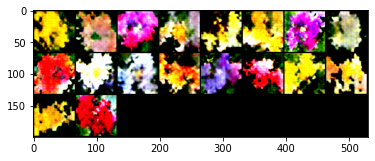

100%|██████████| 103/103 [00:52<00:00,  1.97it/s]


epoch: 46, lossD:1.9348087958919191, lossG:2.2048123831887847,lossG_fake:1.105461642580125, lossG_real:1.0993507475528903 ,equality:0.0061108950272346085


evaluate:109.95832061767578,kid_mean:0.07494430243968964, kid_std:0.04190105199813843,kid_:(tensor(0.0749), tensor(0.0419))


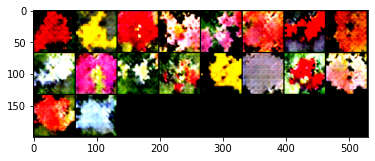

100%|██████████| 103/103 [00:51<00:00,  1.99it/s]


epoch: 47, lossD:1.9347995762686128, lossG:2.179793876351662,lossG_fake:1.1108264546949886, lossG_real:1.068967418184558 ,equality:0.04185903651043055


evaluate:110.57079315185547,kid_mean:0.06172379106283188, kid_std:0.03757309541106224,kid_:(tensor(0.0617), tensor(0.0376))


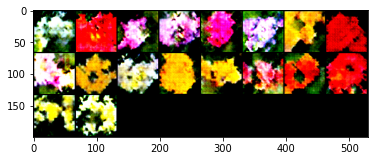

100%|██████████| 103/103 [00:51<00:00,  1.99it/s]


epoch: 48, lossD:1.9029741923785903, lossG:2.266263697911235,lossG_fake:1.1582691113925674, lossG_real:1.1079945888334108 ,equality:0.05027452255915654


evaluate:110.5881118774414,kid_mean:0.07011062651872635, kid_std:0.04559953883290291,kid_:(tensor(0.0701), tensor(0.0456))


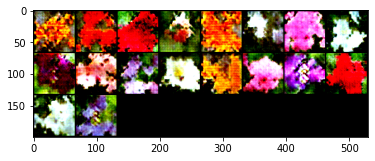

100%|██████████| 103/103 [00:52<00:00,  1.97it/s]


epoch: 49, lossD:1.8870456369177808, lossG:2.315500224678262,lossG_fake:1.1797261052918666, lossG_real:1.1357741118634788 ,equality:0.04395199342838785


evaluate:111.1937255859375,kid_mean:0.06395196169614792, kid_std:0.03433193266391754,kid_:(tensor(0.0640), tensor(0.0343))


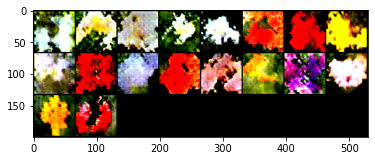

In [ ]:
lossesD = []
lossesG = []

raw_lossesD = []
raw_lossesG = []
lossesG_fake = []
lossesG_real = []

equality = 0.0
sum_equality = 0.0
d_equality = []

relu = torch.nn.ReLU()

fid_ = []
kid_mean_ = []
kid_std_ = []
kid_score = []
for epoch in range(opt.n_epoch):
    running_lossD = 0.0 #損失関数初期化
    running_lossG = 0.0
    lossG_fake_running = 0.0
    lossG_real_running = 0.0

    #sum_equality += equality 
    equality = 0.0
   # for i , (real_imgs, _) in enumerate(tqdm.tqdm(dataloader, position = 0)):#celebA
    for i , real_imgs in enumerate(tqdm.tqdm(dataloader, position = 0)):#flower
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size()[0]
        noise = torch.randn(batch_size, opt.z_dim, 1, 1).to(device)

        #train discriminator

        netD.zero_grad()
        output_real = netD(real_imgs)

        #lossD_real = criterion(output, labels_real)
        lossD_real = torch.mean(relu(1.0 - output_real))


        fake_imgs = netG(noise)##not train  output_fake_d
        output_fake_d = netD(fake_imgs.detach())#not train  output_fake_d

        #lossD_fake = criterion(output, labels_fake)
        lossD_fake = torch.mean(relu(1.0 + output_fake_d))
        

        lossD = lossD_real + lossD_fake
        #lossD = torch.mean(torch.log(torch.sigmoid(output_real)))- torch.mean(torch.log(torch.sigmoid(output_fake_d)))  #not train  output_fake_d
        lossD.backward()
        optimizerD.step()
        
        #train generator
        
        netG.zero_grad()#勾配初期

        output_fake_g = netD(fake_imgs)#train  output_fake_g
        output_real = netD(real_imgs)

        lossG_fake = torch.mean(relu(1.0 - output_fake_g))
        lossG_real = torch.mean(relu(1.0 + output_real))
        #lossG =  torch.mean(torch.log(torch.sigmoid(output_fake_g - output_real))) #- torch.mean(torch.log(torch.sigmoid(output_real)))#train  output_fake_g
        lossG =    lossG_real + lossG_fake    


        lossG.backward()
        optimizerG.step()
        
        # save loss
        
        running_lossD += lossD.item()
        running_lossG += lossG.item()
        
        raw_lossesD.append(lossD.item())
        raw_lossesG.append(lossG.item())

        lossG_fake_running += lossG_fake.item()
        lossG_real_running += lossG_real.item()


        
    running_lossD /=len(dataloader)
    running_lossG /=len(dataloader)

    lossG_fake_running /= len(dataloader)
    lossG_real_running /= len(dataloader)
#equality
    equality = ( lossG_fake_running - lossG_real_running  )
    d_equality.append(equality)


    print("epoch: {}, lossD:{}, lossG:{},lossG_fake:{}, lossG_real:{} ,equality:{}".format(epoch, running_lossD, running_lossG,lossG_fake_running,lossG_real_running,equality))#-->,lossG_fake:{}, lossG_real:{},lossG_fake_running,lossG_real_running
    lossesD.append(running_lossD)
    lossesG.append(running_lossG)

    lossesG_fake.append(lossG_fake_running)
    lossesG_real.append(lossG_real_running)

     #evaluate GAN
    fake_imgs_1 = fake_imgs.detach()
    real_imgs_1 = real_imgs.to(dtype=torch.uint8).cpu()
    fake_imgs_1 = fake_imgs_1.to(dtype=torch.uint8).cpu()
    fid.update(real_imgs_1, real=True)
    fid.update(fake_imgs_1, real=False)
    eval = fid.compute()

    kid.update(real_imgs_1, real=True)
    kid.update(fake_imgs_1, real=False)
    kid_ = kid.compute()
    kid_mean, kid_std = kid.compute()

    
  
    print("evaluate:{},kid_mean:{}, kid_std:{},kid_:{}".format(eval, kid_mean, kid_std, kid_))
    fid_.append(eval)
    kid_mean_.append(kid_mean)
    kid_std_.append(kid_std)
    kid_score.append(kid_)
    #show fake image
    grid_imgs = vutils.make_grid(fake_imgs[:24].detach()+0.5)
    grid_imgs_arr = grid_imgs.cpu().numpy()
    plt.imshow(np.transpose(grid_imgs_arr, (1,2,0)))
    plt.show()

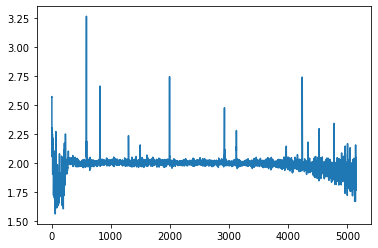

In [ ]:
plt.plot(raw_lossesD)

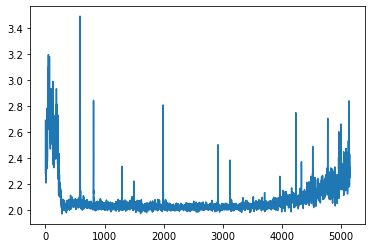

In [ ]:
plt.plot(raw_lossesG)

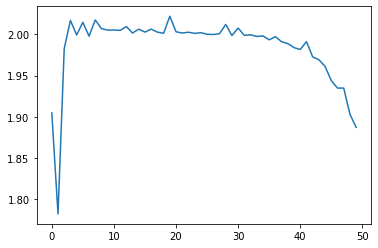

In [ ]:
plt.plot(lossesD)

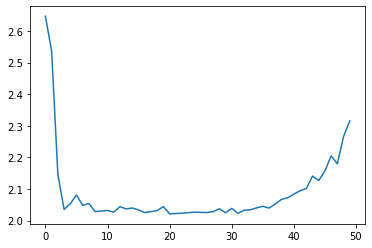

In [ ]:
plt.plot(lossesG)

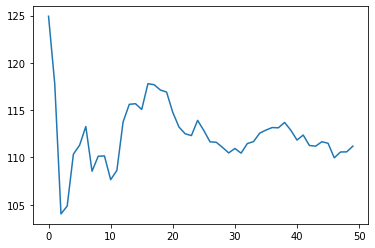

In [ ]:
plt.plot(fid_)

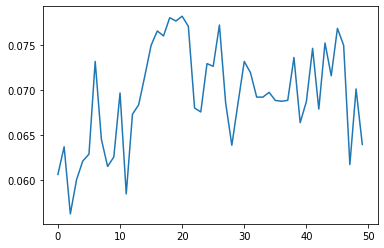

In [ ]:
plt.plot(kid_mean_)

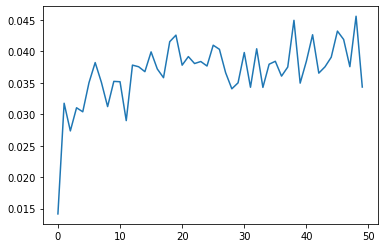

In [ ]:
plt.plot(kid_std_)

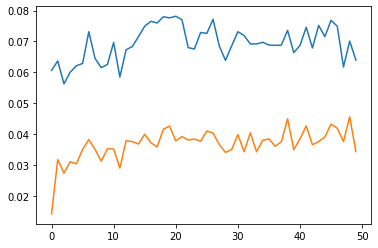

In [ ]:
plt.plot(kid_score)

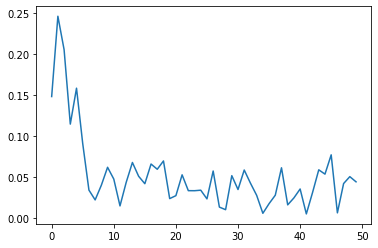

In [ ]:
plt.plot(d_equality)

In [ ]:

real_imgs = real_imgs.to(dtype=torch.uint8).cpu()
fake_imgs = fake_imgs.to(dtype=torch.uint8).cpu()
fid.update(real_imgs, real=True)
fid.update(fake_imgs, real=False)
fid.compute()

kid.update(real_imgs, real=True)
kid.update(fake_imgs, real=False)
kid.compute()

(tensor(0.0696), tensor(0.0370))